In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

In [2]:
cid = ""
secret = ""
username = ""
redirect_uri = "http://localhost:9000/callback"

In [3]:
scope = 'user-library-read playlist-modify-public playlist-read-private'

client_credentials_manager = SpotifyClientCredentials(client_id = cid, client_secret=secret)

sp = spotipy.Spotify(client_credentials_manager= client_credentials_manager)

token = util.prompt_for_user_token(username,scope,cid,secret,redirect_uri)

if token:
  sp = spotipy.Spotify(auth=token)
  
else:
  print("Can't get token for", username)

In [4]:
import pandas as pd

#
sourcePlaylistID = ''
sourcePlaylist = sp.user_playlist(username,sourcePlaylistID);
tracks = sourcePlaylist["tracks"];
songs = tracks["items"];

track_ids = []
track_names = []


for i in range(0, len(songs)):
  if songs[i]['track']['id']!=None:
    track_ids.append(songs[i]['track']['id'])
    track_names.append(songs[i]['track']['name'])
    
features = []


for i in range(0,len(track_ids)):
  audio_features  = sp.audio_features(track_ids[i])
  for track in audio_features:
    features.append(track)
    
    
playlist_df = pd.DataFrame(features,index = track_names)


In [5]:
playlist_df = playlist_df[["id", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness",  "key", "liveness", "loudness", "mode", "speechiness", "tempo", "valence"]]


In [6]:
playlist_df.shape


(10, 13)

In [7]:
playlist_df['ratings']=[10, 9, 9, 10, 8, 6, 8, 4, 3, 7]


In [8]:
playlist_df

,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,ratings
Bam Bam (feat. Ed Sheeran),2DB4DdfCFMw1iaR6JaR03a,0.1820,0.756,206071,0.697,0.00000,8,0.333,-6.377,1,0.0401,94.996,0.956,10
When You're Gone,0U1W2LZVUX7qTm7dDpqxh6,0.0248,0.603,172267,0.691,0.00000,5,0.583,-5.805,1,0.0372,147.148,0.577,9
34+35,6Im9k8u9iIzKMrmV7BWtlF,0.2370,0.830,173711,0.585,0.00000,0,0.248,-6.476,1,0.0940,109.978,0.485,9
Wildest Dreams,3fVnlF4pGqWI9flVENcT28,0.0709,0.553,220440,0.664,0.00560,8,0.106,-7.417,1,0.0741,140.060,0.467,10
Story of My Life,4nVBt6MZDDP6tRVdQTgxJg,0.2250,0.600,245493,0.663,0.00000,3,0.119,-5.802,1,0.0477,121.070,0.286,8
Levitating,39LLxExYz6ewLAcYrzQQyP,0.0561,0.695,203808,0.884,0.00000,6,0.213,-2.278,0,0.0753,103.014,0.914,6
Rude,6RtPijgfPKROxEzTHNRiDp,0.0422,0.773,224840,0.758,0.00000,1,0.305,-4.993,1,0.0381,144.033,0.925,8
Lights,11ozIUBoXAgRTVWelDn4pL,0.0721,0.703,244267,0.731,0.00191,8,0.138,-6.283,0,0.0311,120.028,0.719,4
Heart Attack,1V6gIisPpYqgFeWbMLI0bA,0.0738,0.504,210840,0.785,0.00000,8,0.239,-4.802,1,0.1040,173.968,0.502,3
Love Me Like You Do,0Cy7wt6IlRfBPHXXjmZbcP,0.2700,0.489,253520,0.597,0.00000,5,0.105,-6.633,0,0.0292,95.012,0.324,7


In [9]:
X_train = playlist_df.drop(['id', 'ratings'], axis=1)
y_train = playlist_df['ratings']

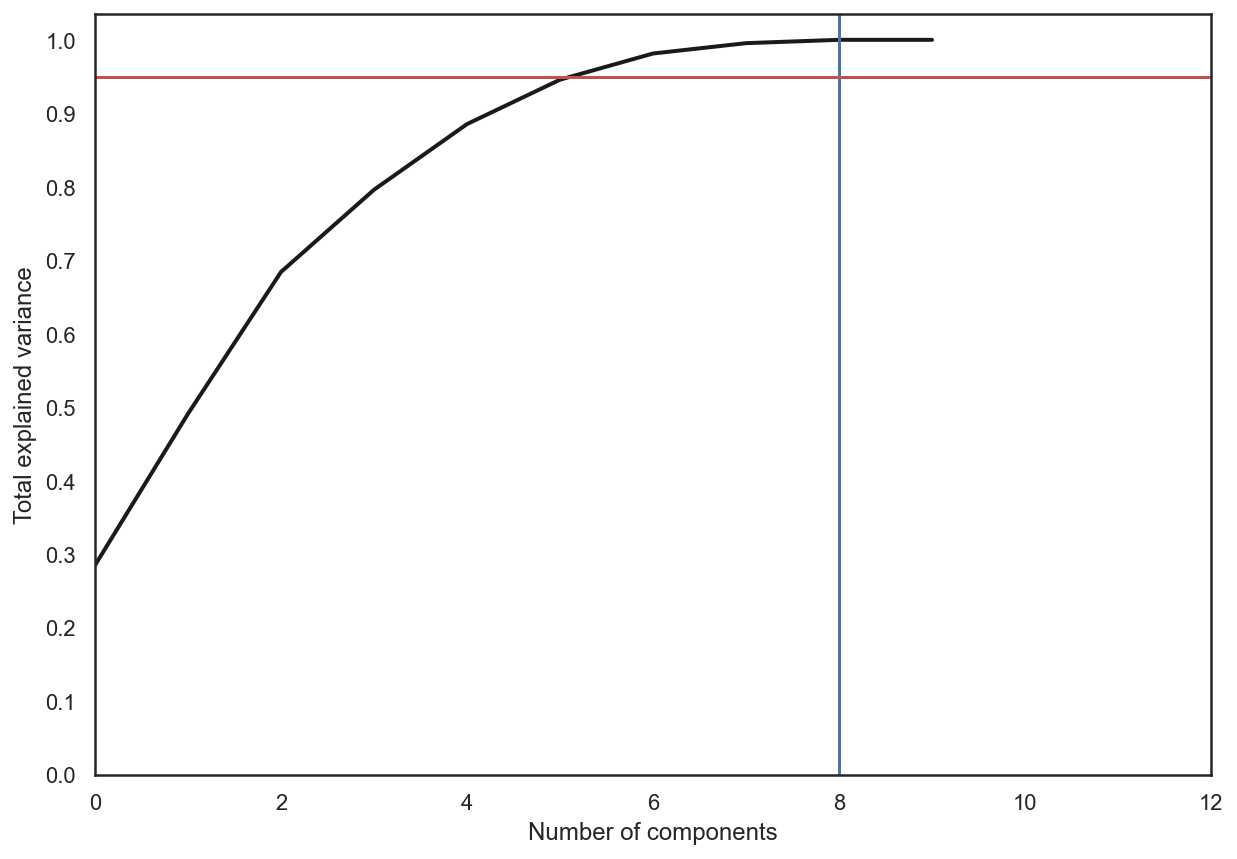

In [10]:
import numpy as np
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

X_scaled = StandardScaler().fit_transform(X_train)

pca = decomposition.PCA().fit(X_scaled)


plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='k',lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0,12)
plt.yticks(np.arange(0,1.1,0.1))
plt.axvline(8,c='b')
plt.axhline(0.95,c='r')
plt.show();

In [11]:
# Fit your dataset to the optimal pca
pca = decomposition.PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(sublinear_tf = True, ngram_range=(1,6),
                   max_features=10000)
X_names_sparse=v.fit_transform(track_names)
X_names_sparse.shape

(10, 60)

In [13]:
from scipy.sparse import csr_matrix, hstack

X_train_last = csr_matrix(hstack([X_pca, X_names_sparse]))

In [14]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

skf = StratifiedKFold(n_splits=2,shuffle=True,random_state=42)

In [15]:
from sklearn.neighbors import KNeighborsClassifier

knn_params = {'n_neighbors':range(1,10)}
knn = KNeighborsClassifier(n_jobs=-1)

knn_grid= GridSearchCV(knn,knn_params,cv=skf,n_jobs =-1,verbose=True)
knn_grid.fit(X_train_last,y_train)
knn_grid.best_params_, knn_grid.best_score_

Fitting 2 folds for each of 9 candidates, totalling 18 fits


C:\Users\acer\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.1 0.1 0.  0.  0.  nan nan nan nan]
  warnings.warn(


({'n_neighbors': 1}, 0.1)

In [16]:
from sklearn.ensemble import RandomForestClassifier
parameters = {'max_features':[4,7,8,10],'min_samples_leaf':[1,3,5,8],'max_depth':[3,5,8]}
rfc = RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1,oob_score=True)
forest_grid = GridSearchCV(rfc,parameters,n_jobs=-1,cv=skf,verbose=1)
forest_grid.fit(X_train_last,y_train)
forest_grid.best_estimator_ , forest_grid.best_score_

Fitting 2 folds for each of 48 candidates, totalling 96 fits


C:\Users\acer\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


(RandomForestClassifier(max_depth=3, max_features=4, n_jobs=-1, oob_score=True,
                        random_state=42),
 nan)

In [17]:
from sklearn.tree import DecisionTreeClassifier

tree= DecisionTreeClassifier()

tree_params = {'max_depth':range(1,11),'max_features':range(4,19)}
tree_grid = GridSearchCV(tree,tree_params,cv=skf,n_jobs=-1,verbose=True)
tree_grid.fit(X_train_last,y_train)
tree_grid.best_estimator_ , tree_grid.best_score_


Fitting 2 folds for each of 150 candidates, totalling 300 fits


C:\Users\acer\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


(DecisionTreeClassifier(max_depth=5, max_features=13), 0.30000000000000004)

In [18]:
rec_tracks=[]

for i in playlist_df['id'].values.tolist():
  rec_tracks += sp.recommendations(seed_tracks=[i],limit = int(len(playlist_df)/2))['tracks'];
  

rec_track_ids=[]
rec_track_names = []
for i in rec_tracks:
  rec_track_ids.append(i['id'])
  rec_track_names.append(i['name'])

In [19]:
rec_features=[]

for i in range(0,len(rec_track_ids)):
  rec_audio_features = sp.audio_features(rec_track_ids[i])
  for track in rec_audio_features:
    rec_features.append(track)
    
    
rec_playlist_df= pd.DataFrame(rec_features,index = rec_track_ids)

In [20]:
rec_playlist_df = rec_playlist_df[["acousticness", "danceability", "duration_ms", "energy", "instrumentalness",  "key", "liveness", "loudness", "mode", "speechiness", "tempo", "valence"]]


In [21]:
tree_grid.best_estimator_.fit(X_train_last,y_train)
rec_playlist_df_scaled = StandardScaler().fit_transform(rec_playlist_df)
X_test_pca  = pca.transform(rec_playlist_df_scaled)
X_test_names = v.transform(rec_track_names)
X_test_last = csr_matrix(hstack([X_test_pca,X_test_names]))
y_pred_class = tree_grid.best_estimator_.predict(X_test_last)

In [22]:
rec_playlist_df['ratings']=y_pred_class
rec_playlist_df = rec_playlist_df.sort_values('ratings',ascending=False)
rec_playlist_df = rec_playlist_df.reset_index()
recs_to_add = rec_playlist_df[rec_playlist_df['ratings']>=9]['index'].values.tolist()

In [23]:
username = '31fggg7ujoft7ljztwddvqiliqgi'
playlist_recs =sp.user_playlist_create(username,name="Recommended Songs for Playlist - {}".format(sourcePlaylist['name']))

In [24]:
playlist_recs

{'collaborative': False,
 'description': '',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/15c2DAkpRH8DAm0qLpH0ze'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/playlists/15c2DAkpRH8DAm0qLpH0ze',
 'id': '15c2DAkpRH8DAm0qLpH0ze',
 'images': [],
 'name': "Recommended Songs for Playlist - DS'",
 'owner': {'display_name': 'Dhvanish Samanta',
  'external_urls': {'spotify': 'https://open.spotify.com/user/31fggg7ujoft7ljztwddvqiliqgi'},
  'href': 'https://api.spotify.com/v1/users/31fggg7ujoft7ljztwddvqiliqgi',
  'id': '31fggg7ujoft7ljztwddvqiliqgi',
  'type': 'user',
  'uri': 'spotify:user:31fggg7ujoft7ljztwddvqiliqgi'},
 'primary_color': None,
 'public': True,
 'snapshot_id': 'MSwzNDJkOGJkMWJhZTMyNGM3ZjJlZmZlYmMzOTc4ZTk2OTA0YWJmNmEz',
 'tracks': {'href': 'https://api.spotify.com/v1/playlists/15c2DAkpRH8DAm0qLpH0ze/tracks',
  'items': [],
  'limit': 100,
  'next': None,
  'offset': 0,
  'previous': None,
  'total': 0},
 'type': 'playlist',

In [25]:
len(recs_to_add)

23

In [26]:
sp.user_playlist_add_tracks(username,playlist_recs['id'],recs_to_add);
